In [2]:
import pandas as pd

df_filtered = pd.read_csv("Cleaned Dataset.csv")

In [28]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Step 1: Load the dataset
df_filtered = pd.read_csv("Cleaned Dataset.csv")

# Step 2: Perform One-Hot Encoding for categorical variables like 'Sex' and 'Ethnicity'
df_filtered_encoded = pd.get_dummies(df_filtered, columns=['Sex', 'Ethnicity'], drop_first=True)

# Step 3: Select relevant features for matching (e.g., age, disease count, and comorbidities)
matching_features = ['Age', 'Disease Count'] + [col for col in df_filtered_encoded.columns if col.startswith('Sex_') or col.startswith('Ethnicity_')]

# Create the feature matrix X (use the selected features for matching)
X = df_filtered_encoded[matching_features]

# Step 4: Normalize the features for better distance computation in KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Separate PH and non-PH patients
df_ph = df_filtered_encoded[df_filtered_encoded['PH'] == 1]  # PH patients
df_non_ph = df_filtered_encoded[df_filtered_encoded['PH'] == 0]  # Non-PH patients

# Step 6: Perform KNN to find closest non-PH patients for each PH patient
knn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
knn.fit(df_non_ph[matching_features])

# Step 7: Find the nearest non-PH patients for each PH patient
distances, indices = knn.kneighbors(df_ph[matching_features])

# Step 8: Retrieve the matched non-PH patients based on the indices
matched_non_ph = df_non_ph.iloc[indices.flatten()]

# Step 9: Combine matched PH and non-PH patients into one matched dataset
matched_dataset = pd.concat([df_ph, matched_non_ph], axis=0)

# Step 10: Check the number of unique PH and non-PH patients in the matched dataset
print(f"Number of PH patients in Matched Dataset: {df_ph.shape[0]}")
print(f"Number of Non-PH patients in Matched Dataset: {matched_non_ph.shape[0]}")


matched_dataset.head(5)


Number of PH patients in Matched Dataset: 2571
Number of Non-PH patients in Matched Dataset: 2571


,Participant ID,Dementia,Depression,Stroke,Thyroid disease,Atrial fibrillation,Ischaemic heart disease,Left heart failure,Myocardial infarction,Valvular disease,...,Chronic liver disease,Chronic kidney disease,Diabetes,Essential hypertension,Hypercholesterolemia,PH,Age,Disease Count,Sex_Male,Ethnicity_Non-British
131,1004321,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,85.0,2,False,False
232,1007589,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,80.0,4,True,False
246,1008275,0,1,0,0,1,1,1,0,0,...,0,0,0,1,1,1,85.0,7,False,False
310,1010363,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,59.0,2,False,True
418,1013750,0,0,0,1,0,1,1,0,1,...,0,0,0,1,1,1,84.0,8,True,False


In [31]:
# Check for duplicates
duplicates = df_filtered[df_filtered.duplicated(subset=['Participant ID'], keep=False)]

# If you want to check the duplicates
print(duplicates)

# Remove the duplicates
df_filtered_unique = df_filtered.drop_duplicates(subset=['Participant ID'])

# Check the number of unique participants after removing duplicates
print(f"Number of unique participants after removing duplicates: {df_filtered_unique['Participant ID'].nunique()}")

Empty DataFrame
Columns: [Participant ID, Dementia, Depression, Stroke, Thyroid disease, Atrial fibrillation, Ischaemic heart disease, Left heart failure, Myocardial infarction, Valvular disease, Cardiomyopathy, COPD, Sleep apnoea, Asthma, Restrictive airway disease, Pulmonary embolism, Chronic liver disease, Chronic kidney disease, Diabetes, Essential hypertension, Hypercholesterolemia, PH, Sex, Age, Ethnicity, Disease Count]
Index: []

[0 rows x 26 columns]
Number of unique participants after removing duplicates: 152854


In [37]:
from sklearn.utils import resample

# Over-sample non-PH to match the number of PH patients (2571)
df_non_ph_oversampled = resample(df_non_ph_unique,
                                  replace=True,  # Sample with replacement
                                  n_samples=2571,  # Match PH patients
                                  random_state=42)
print(f"Number of non-PH after over-sampling: {df_non_ph_oversampled.shape[0]}")


Number of non-PH after over-sampling: 2571


In [38]:
# Combine PH and over-sampled non-PH patients into one matched dataset
matched_dataset = pd.concat([df_filtered[df_filtered['PH'] == 1], df_non_ph_oversampled])

# Check the new distribution of PH and non-PH patients
print(f"New matched dataset contains {df_matched['PH'].value_counts()}")


New matched dataset contains PH
1    2571
0    2571
Name: count, dtype: int64


In [42]:
# Step 1: Remove duplicates
df_unique = df_filtered.drop_duplicates(subset='Participant ID')

# Step 2: Check the new unique count of PH and non-PH participants
unique_ph = df_unique[df_unique['PH'] == 1]
unique_non_ph = df_unique[df_unique['PH'] == 0]

# Step 3: Check the number of unique participants after dropping duplicates
print(f"Number of unique PH participants: {len(unique_ph)}")
print(f"Number of unique non-PH participants: {len(unique_non_ph)}")

# Step 4: If there are fewer than 2571 non-PH participants, sample randomly from original non-PH cohort
if len(unique_non_ph) < 2571:
    # Randomly sample from the original non-PH cohort (before removing duplicates) to get 2571 unique non-PH
    df_non_ph_original = df_filtered[df_filtered['PH'] == 0]
    non_ph_sampled = df_non_ph_original.sample(n=2571, random_state=42)
else:
    # If there are already enough unique non-PH participants, just take 2571 of them
    non_ph_sampled = unique_non_ph.sample(n=2571, random_state=42)

# Step 5: Create the matched dataset by combining PH and non-PH patients
matched_dataset = pd.concat([unique_ph.sample(n=2571, random_state=42), non_ph_sampled])

# Step 6: Verify the result
print(f"Matched Dataset contains: {matched_dataset['PH'].value_counts()}")

Number of unique PH participants: 2571
Number of unique non-PH participants: 150283
Matched Dataset contains: PH
1    2571
0    2571
Name: count, dtype: int64


In [45]:
matched_dataset.to_csv("Matched_Cohort.csv", index=False)

In [43]:
unique_participants = matched_dataset['Participant ID'].nunique()

print(f"Number of unique participants in the cohort: {unique_participants}")

ph_counts = matched_dataset['PH'].value_counts()

print(f"Number of participants with PH: {ph_counts[1]}")
print(f"Number of participants without PH: {ph_counts[0]}")

# Check the distribution of PH values
print(matched_dataset['PH'].value_counts())

# Check if there are duplicate participant IDs
duplicates = matched_dataset[matched_dataset.duplicated(subset=['Participant ID'])]
print(f"Number of duplicates in the dataset: {duplicates.shape[0]}")

# Count unique participants in each group
ph_counts_unique = matched_dataset.groupby('PH')['Participant ID'].nunique()
print(f"Unique participants with PH: {ph_counts_unique[1]}")
print(f"Unique participants without PH: {ph_counts_unique[0]}")

Number of unique participants in the cohort: 5142
Number of participants with PH: 2571
Number of participants without PH: 2571
PH
1    2571
0    2571
Name: count, dtype: int64
Number of duplicates in the dataset: 0
Unique participants with PH: 2571
Unique participants without PH: 2571


In [44]:
# Check the distribution of PH values
print(matched_dataset['PH'].value_counts())

PH
1    2571
0    2571
Name: count, dtype: int64


In [46]:
# Step 1: Split the matched dataset into PH and non-PH patients
df_ph_matched = matched_dataset[matched_dataset['PH'] == 1]  # PH patients
df_non_ph_matched = matched_dataset[matched_dataset['PH'] == 0]  # non-PH patients

# Check the sizes of each group
print(f"Number of PH Patients in Matched Dataset: {df_ph_matched.shape[0]}")
print(f"Number of Non-PH Patients in Matched Dataset: {df_non_ph_matched.shape[0]}")

Number of PH Patients in Matched Dataset: 2571
Number of Non-PH Patients in Matched Dataset: 2571


In [47]:
df_ph_matched.head(5)

,Participant ID,Dementia,Depression,Stroke,Thyroid disease,Atrial fibrillation,Ischaemic heart disease,Left heart failure,Myocardial infarction,Valvular disease,...,Chronic liver disease,Chronic kidney disease,Diabetes,Essential hypertension,Hypercholesterolemia,PH,Sex,Age,Ethnicity,Disease Count
68772,3263701,0,0,0,0,1,1,1,0,1,...,1,1,0,1,0,1,Female,85.0,British,7
126594,5162291,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,Female,85.0,British,2
147495,5850901,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,1,Male,71.0,British,4
22285,1726911,1,0,0,1,1,1,1,0,0,...,0,1,1,1,1,1,Female,84.0,British,11
107142,4521606,0,0,0,0,1,1,0,0,0,...,0,0,0,1,0,1,Male,76.0,British,4


In [48]:
df_non_ph_matched.head(5)

,Participant ID,Dementia,Depression,Stroke,Thyroid disease,Atrial fibrillation,Ischaemic heart disease,Left heart failure,Myocardial infarction,Valvular disease,...,Chronic liver disease,Chronic kidney disease,Diabetes,Essential hypertension,Hypercholesterolemia,PH,Sex,Age,Ethnicity,Disease Count
27082,1883664,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,Male,81.0,British,2
144222,5743656,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,Male,83.0,British,3
113411,4725300,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,Male,79.0,British,2
114177,4751257,0,0,0,0,0,1,0,0,0,...,0,1,1,1,1,0,Female,71.0,British,6
96310,4165786,1,0,0,1,0,0,0,0,0,...,0,0,1,1,1,0,Male,79.0,British,5


In [49]:
df_ph_matched.to_csv('Matched PH.csv', index=False)
df_non_ph_matched.to_csv('Matched Non-PH.csv', index=False)

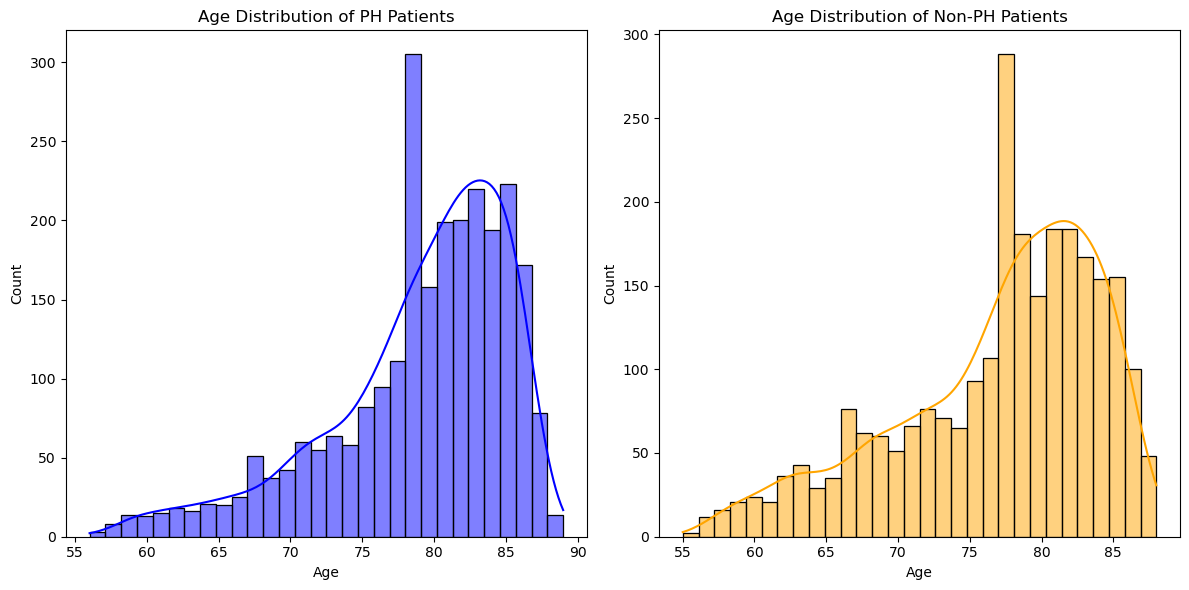

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 3: Visualize Age Distribution for PH and non-PH patients
plt.figure(figsize=(12, 6))

# PH Age Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_ph_matched['Age'], kde=True, color='blue', bins=30)
plt.title('Age Distribution of PH Patients')
plt.xlabel('Age')

# Non-PH Age Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_non_ph_matched['Age'], kde=True, color='orange', bins=30)
plt.title('Age Distribution of Non-PH Patients')
plt.xlabel('Age')

plt.tight_layout()
plt.show()


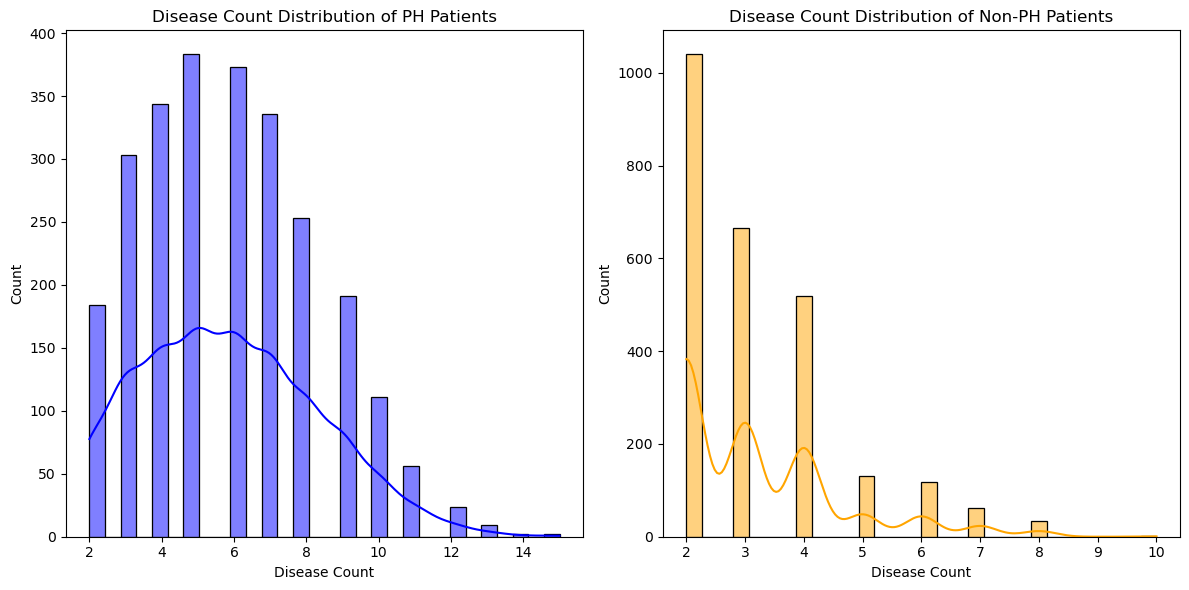

In [ ]:
# Step 4: Visualize Disease Count for PH and non-PH patients
plt.figure(figsize=(12, 6))

# PH Disease Count Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_ph_matched['Disease Count'], kde=True, color='blue', bins=30)
plt.title('Disease Count Distribution of PH Patients')
plt.xlabel('Disease Count')

# Non-PH Disease Count Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_non_ph_matched['Disease Count'], kde=True, color='orange', bins=30)
plt.title('Disease Count Distribution of Non-PH Patients')
plt.xlabel('Disease Count')

plt.tight_layout()
plt.show()
